# Projection and BackProjection in Python

### The Radon Transform

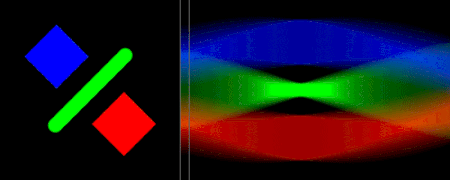

In [1]:

from IPython.display import Image as IPImage
with open(r'C:\Users\oli_n\pycode\R4 Didactic\anims\Radon_transform_sinogram.gif','rb') as file:
    display(IPImage(file.read()))

### A nice illustrative animation of the [forward] Radon Transform

    - From https://commons.wikimedia.org/wiki/File:Radon_transform_sinogram.gif

Lets experiment with the python implementation of the Radon Transform in SciKit Image.

We need to load an image to convert to a sinogram.  Let's use a brain.

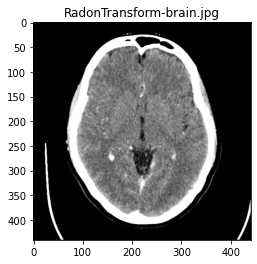

In [2]:
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
import pydicom
from PIL import Image

from skimage.transform import radon


input_image = Image.open(r'C:\Users\oli_n\pycode\R4 Didactic\RadonTranform-brain.jpg').convert(mode='L')
image = np.asarray(input_image)

plt.title("RadonTransform-brain.jpg")
plt.imshow(image, cmap=plt.cm.Greys_r)
plt.show()


Now we need to calculate the radon transform from this original image.

To do this we create a list of angles which will be the angles of projection.

We use the numpy function np.linspace to generate this list of numbers, ranging from 0 to -180 degrees.  This is created in a number of steps determined by the length of the longer side of the input image:

     max(image.shape)


C:\Users\oli_n\anaconda3\lib\site-packages\skimage\transform\radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


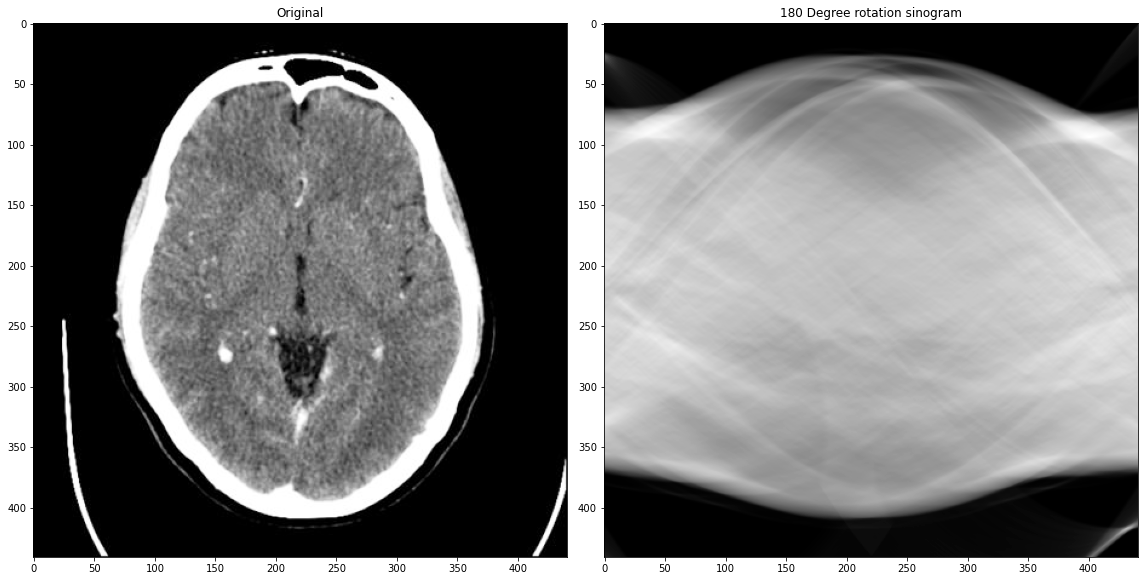

In [3]:
theta = np.linspace(0., -180., max(image.shape), endpoint=False)

sinogram = radon(image, theta=theta)

# -------------------------------------------------------
# Now display the two images side by side

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

ax2.set_title('180 Degree rotation sinogram')
ax2.imshow(sinogram, cmap=plt.cm.Greys_r)#,

fig.tight_layout()
plt.show()

### And back again?

We need to import the inverse Radon transformation: iradon

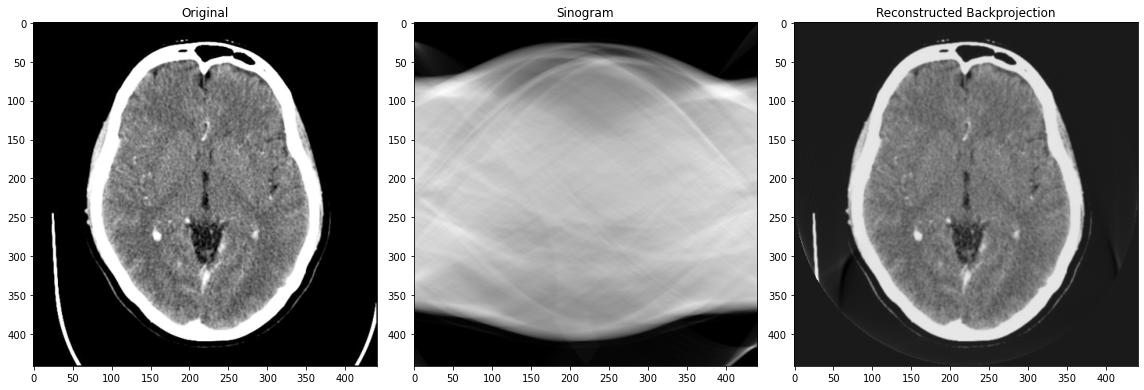

In [4]:
from skimage.transform import iradon


theta = np.linspace(0., -180., max(image.shape), endpoint=False)

backprojection = iradon(sinogram, theta=theta)

# -------------------------------------------------------
# Now display the two images side by side

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 9))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

ax2.set_title("Sinogram")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r)

ax3.set_title('Reconstructed Backprojection')
ax3.imshow(backprojection, cmap=plt.cm.Greys_r)

fig.tight_layout()
plt.show()

There we go- from original image, to sinogram and back again.

You may notice the difference between the original and the backprojected images - this loss of clarity is due to the loss of high spatial frequency information.  

#### The same thing happens when scanning patients

This is why we usually perform a _Filtered_ Back Projection (FBP), enhancing the high spatial frequency information with a ramp filter (or similar).

## Can we start with some else's sinogram?

They are actually difficult to find.  But here's one I managed to google.

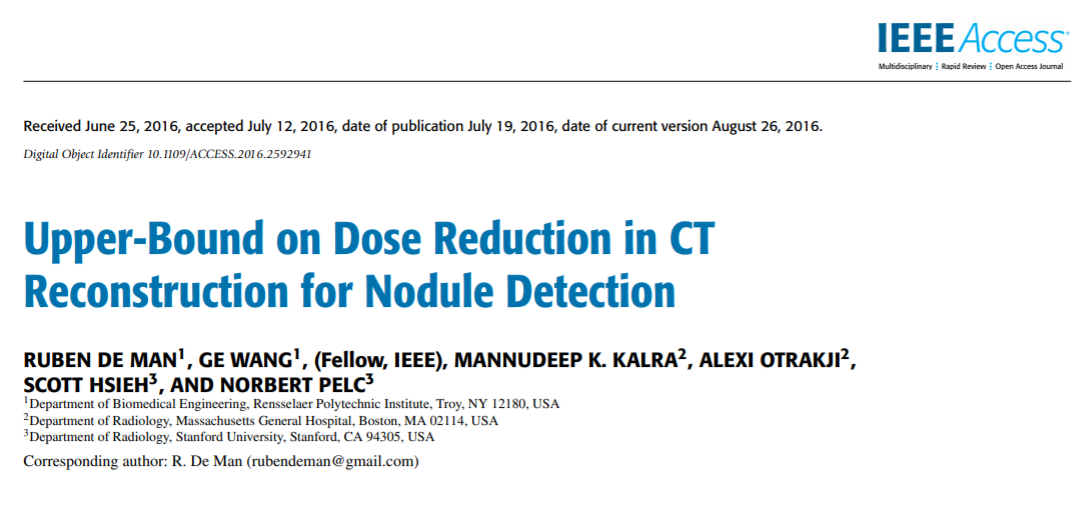


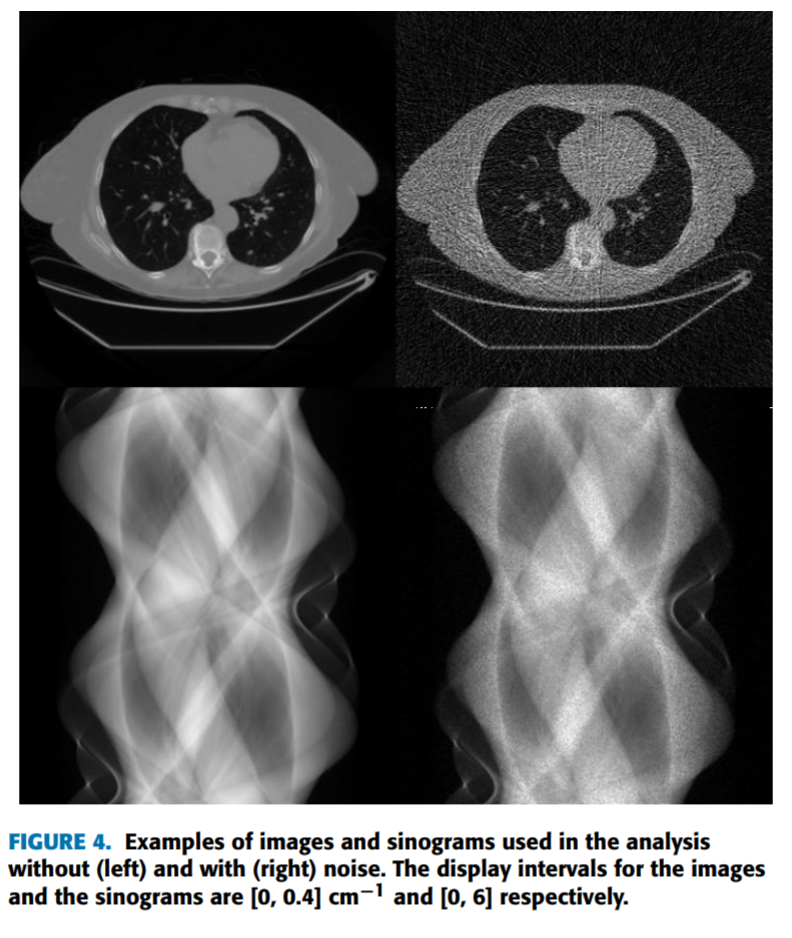



### so I downloaded the image - this needed cropping and rotating.

I call it 'hacky_sinogram'

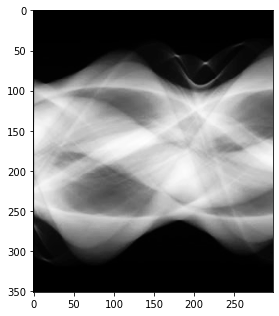

In [5]:
net_sinogram_image = Image.open(r'C:\Users\oli_n\pycode\R4 Didactic\RadonTransform_Internet_Sinogram.png').convert(mode='L')

hacky_sinogram = np.asarray(net_sinogram_image)


# -------------------------------------------------------------------
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 4.5))

ax1.imshow(net_sinogram_image, cmap=plt.cm.Greys_r)

fig.tight_layout()
plt.show()
# -------------------------------------------------------------------


##### I think I cropped off too much - this doesn't look like a 360 degree rotation.  That's a problem.

This sinogram covers somewhere around 180-360 degrees rotation, likely somewhere around 270 degrees.  If we get this number wrong it will look odd.

#### So I guessed.

I turned the reverse process into a function with the angle of rotation as an argument.

As before, the number of pixels (columns) in the sinogram is the number of projections

In [6]:
from skimage.transform import iradon

def get_part_backprojection(sinogram_in=None, proportion=1, show_images=False, save=False, rot_ang = -270., adj_angle=0):

    x, y = sinogram_in.shape

    theta = np.linspace(0.+adj_angle, rot_ang+adj_angle, y, endpoint=False)

    sinogram_part = sinogram_in.copy()
    sinogram_part[:,int(proportion * x):] = 0

    reconstruction_fbp = iradon(sinogram_part, theta=(proportion * theta))

    if show_images:
        imkwargs = dict(vmin=-0.2, vmax=0.2)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                                       sharex=True, sharey=True)
        ax1.set_title("Reconstruction\nBack projection")
        ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
        ax2.set_title(f"Original Sinogram {proportion*100}%")
        ax2.imshow(sinogram_part, cmap=plt.cm.Greys_r)
        plt.show()

    return reconstruction_fbp


This lets you try multiple different values easily

Here I try 180 to 360 degrees in steps of 5 degrees

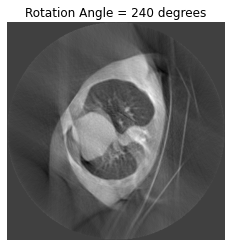

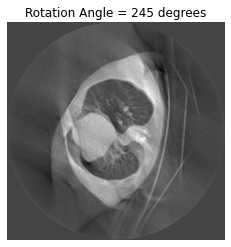

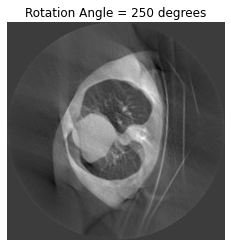

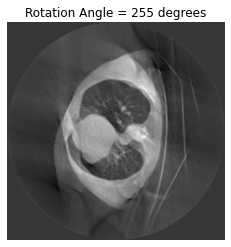

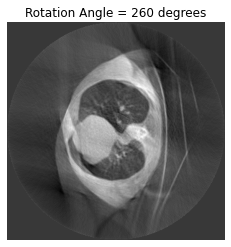

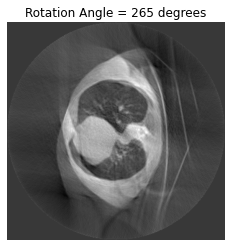

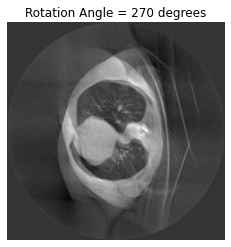

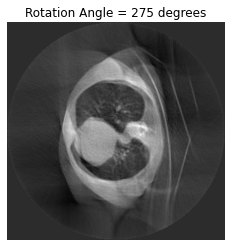

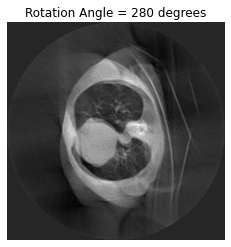

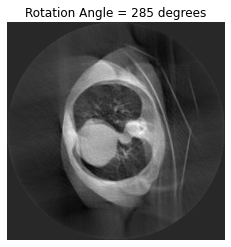

<Figure size 432x288 with 0 Axes>

In [7]:
for angle in range(240, 290, 5):

    hack_out = get_part_backprojection(sinogram_in=hacky_sinogram,
                                       proportion=(100/100),
                                       rot_ang=angle
                                      )

    plt.title(f'Rotation Angle = {angle} degrees')
    plt.axis('off')
    plt.imshow(hack_out, cmap='gray')
    plt.show()

    plt.savefig(f'C:\\Users\\oli_n\\pycode\\R4 Didactic\\reverse_sinogram_frames\\BP [{angle:03}].png', bbox_inches='tight')


#### It looks like around 270 degrees.  Lets get a single nice pic with the sinogram

And have a play with what else we can do with the sinogram

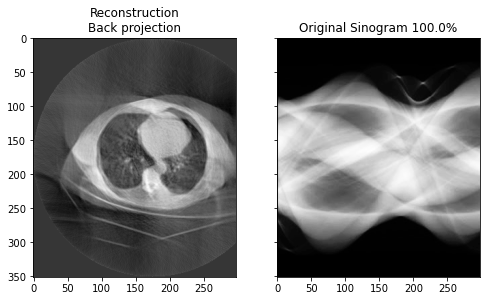

In [14]:
hack_out = get_part_backprojection(sinogram_in=hacky_sinogram,
                                   proportion=(100/100),
                                   show_images=True,
                                   rot_ang=-275,
                                   adj_angle=-90
                                  )


### I though this looked interesting so I generated an animated GIF showing the incremental reconstruction process.

#### In Python of course.

### Step 1 - generate and save the individual frames.  Let's use the brain image as it looks better.

Cheating a bit, I'm resizing the image to make it process faster.

Iteration part = 0/100
Iteration part = 1/100
Iteration part = 2/100
Iteration part = 3/100
Iteration part = 4/100
Iteration part = 5/100
Iteration part = 6/100
Iteration part = 7/100
Iteration part = 8/100
Iteration part = 9/100
Iteration part = 10/100
Iteration part = 11/100
Iteration part = 12/100
Iteration part = 13/100
Iteration part = 14/100
Iteration part = 15/100
Iteration part = 16/100
Iteration part = 17/100
Iteration part = 18/100
Iteration part = 19/100
Iteration part = 20/100
Iteration part = 21/100
Iteration part = 22/100
Iteration part = 23/100
Iteration part = 24/100
Iteration part = 25/100
Iteration part = 26/100
Iteration part = 27/100
Iteration part = 28/100
Iteration part = 29/100
Iteration part = 30/100
Iteration part = 31/100
Iteration part = 32/100
Iteration part = 33/100
Iteration part = 34/100
Iteration part = 35/100
Iteration part = 36/100
Iteration part = 37/100
Iteration part = 38/100
Iteration part = 39/100
Iteration part = 40/100
Iteration part = 41/100
It

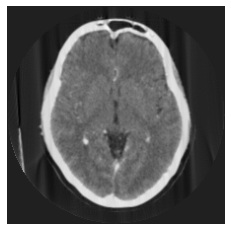

In [15]:
from PIL import Image
from numpy import asarray
import pydicom

input_image = Image.open(r'C:\Users\oli_n\pycode\R4 Didactic\RadonTranform-brain.jpg').convert(mode='L')
input_image = input_image.reduce(2)  # Halve the image size in both dimensions

image_arr = np.asarray(input_image)
theta = np.linspace(0., -180., max(image_arr.shape), endpoint=False)
sinogram = radon(image_arr, theta=theta)


for part in range(0, 100, 1):
    print(f'Iteration part = {part}/100')
    img_n = get_part_backprojection(sinogram_in=sinogram, proportion=(part/100), rot_ang = -180.)
    plt.axis('off')
    plt.imshow(img_n, cmap='gray')
    plt.savefig(f'C:\\Users\\oli_n\\pycode\\R4 Didactic\\FBP_frames\\FBP [{part}].png', bbox_inches='tight')



#### Much code here- This simply cleans up the image (removes the grey at the edges of the image)

#### and

#### stacks up all the images into a single animated GIF

In [16]:
import math
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from skimage.draw import ellipse

TRIM = 22
CIRCLE_ADJ = -6

# Mask the background outside the circle
test=Image.open(f'C:\\Users\\oli_n\\pycode\\R4 Didactic\\FBP_frames\\FBP [0].png').convert('L')
x_size, y_size = np.asarray(test).shape
mask = np.zeros((x_size, y_size), dtype=np.uint8)

mask = np.stack([mask, mask, mask, mask], axis=2)
rr, cc = ellipse(int(x_size/2), int(y_size/2), int(x_size/2)+CIRCLE_ADJ, int(y_size/2)+CIRCLE_ADJ)
mask[rr, cc] = 1


def mask_img(in_image):
    # convert to numpy
    np_array = np.asarray(in_image)

    # mask
    np_array = mask * np_array
    
    # convert back to pil
    pil_im = Image.fromarray(np_array[TRIM:-TRIM,TRIM:-TRIM,:])
    return pil_im

step = 1
imgs = []

for frame in range(1, 100, step):
    new_img = mask_img(Image.open(f'C:\\Users\\oli_n\\pycode\\R4 Didactic\\FBP_frames\\FBP [{frame}].png'))
    imgs.append(new_img)


imgs[0].save(r'C:\Users\oli_n\pycode\R4 Didactic\FBP_brain_wipe_step3_framed.gif',
               save_all=True, append_images=imgs[1:], optimize=False, duration=(20 * step), loop=0)

UnidentifiedImageError: cannot identify image file 'C:\\Users\\oli_n\\pycode\\R4 Didactic\\FBP_frames\\FBP [58].png'

## And we're done!

#### Let's have a look!

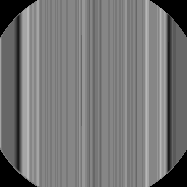

In [17]:
from IPython.display import Image
with open(r'C:\Users\oli_n\pycode\R4 Didactic\FBP_brain_wipe_step3_framed.gif','rb') as file:
    display(Image(file.read()))


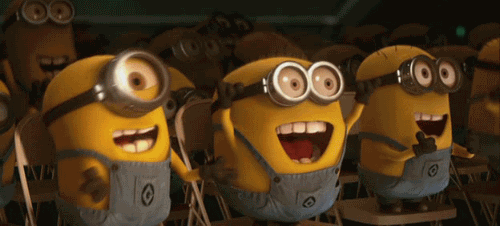

In [18]:
from IPython.display import Image
with open(r'C:\Users\oli_n\pycode\R4 Didactic\anims\minions.gif','rb') as file:
    display(Image(file.read()))
